# TPS data models training

In this notebook several Deep NNs are trained on the Tattoo Paper Substrate device's data.

## Imports

In [7]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from torchmetrics.classification import MulticlassF1Score
import seaborn as sns

## Training Function

In [2]:
# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val, class_weights, train_again = False, lr = 0.0001, lr_step = False):
    # loss function and optimizer
    loss_fn = nn.CrossEntropyLoss(weight = class_weights)  
    optimizer = optim.Adam(model.parameters(), lr= lr)
    
    if lr_step:
        lr_scheduler = ExponentialLR(optimizer, gamma = 0.99)

    if train_again:
        n_epochs = 1000 # number of epochs to run
        batch_size = 5  # size of each batch
    else:
        n_epochs = 500   
        batch_size = 10  
        
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable= True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                _, predicted = torch.max(y_pred, 1)
                F1 = (predicted == y_batch).float().mean()

                # lr_scheduler.step()
                
                bar.set_postfix(
                    loss=float(loss),
                    F1=float(F1)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        f1 = MulticlassF1Score(num_classes= 10) # calculates statistics for each label and computes weighted average using their support
        acc = f1(y_pred, y_val) * 100 
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/1000; F1 Score: {acc}; Loss: {loss}")
            
        if lr_step:
            lr_scheduler.step()
    # restore model with best weights and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

## Model

In [3]:
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(20, 60)
        self.layer2 = nn.Linear(60, 60)
        self.layer3 = nn.Linear(60, 60)
        self.layer4 = nn.Linear(60, 60)
        
        self.act = nn.ReLU()
        self.output = nn.Linear(60, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.act(self.layer3(x))
        x = self.act(self.layer4(x))
        x = self.logsoftmax(self.output(x))
        return x

## Load and Normalize data

In [4]:
TP_df = pd.read_csv('5datasets_13&14&17Jul.csv', sep = ';')
K_df = pd.read_csv('kapton_data.csv', sep = ';')

In [5]:
for c in TP_df.drop(columns = ['AP']).columns:
    K_df[c] = K_df[c] / K_df[c].abs().max()
    TP_df[c] = TP_df[c] / TP_df[c].abs().max()
    

y_TP = TP_df['AP']
X_TP = TP_df.drop(columns = ['AP'])

encoder = LabelEncoder()
encoder.fit(y_TP)
y_TP = encoder.transform(y_TP)

X_TP = torch.tensor(X_TP.values, dtype=torch.float32)
y_TP = torch.tensor(y_TP, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X_TP, y_TP, train_size=0.8, shuffle=True)

## Get Class weights

In [6]:
class_counts = torch.bincount(y_TP)
data_size = len(y_TP)

class_weights = data_size / (len(class_counts) * class_counts)
class_weights

tensor([0.1895, 2.0819, 1.9636, 1.8783, 1.8783, 1.8783, 2.0093, 1.9200, 1.9416,
        1.6615])

# Training

### TPSM 

In [8]:
TPSM = Deep()

acc = model_train(TPSM, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights) # lr = 1e-4
print(f"Achieved F1 Score: {acc:.2f}%")

Epoch 0/1000; F1 Score: 1.2466124296188354; Loss: 2.3282992839813232
Epoch 100/1000; F1 Score: 79.0444564819336; Loss: 0.049844495952129364
Epoch 200/1000; F1 Score: 82.13822174072266; Loss: 0.022861894220113754
Epoch 300/1000; F1 Score: 81.96076965332031; Loss: 0.013825186528265476
Epoch 400/1000; F1 Score: 79.38206481933594; Loss: 0.010981416329741478
Epoch 500/1000; F1 Score: 80.45484161376953; Loss: 0.010331171564757824
Epoch 600/1000; F1 Score: 80.48936462402344; Loss: 0.009421697817742825
Epoch 700/1000; F1 Score: 80.88616180419922; Loss: 0.008044562302529812
Epoch 800/1000; F1 Score: 80.81853485107422; Loss: 0.006352428812533617
Epoch 900/1000; F1 Score: 81.48639678955078; Loss: 0.005903587210923433
Achieved F1 Score: 82.63%


### TPSM1

In [9]:
TPSM1 = Deep()

acc = model_train(TPSM1, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights, lr = 1.5e-3)
print(f"Achieved F1 Score: {acc:.2f}%")
# torch.save(TPSM2, f'{round(acc)}_TPSM2.pth')

Epoch 0/1000; F1 Score: 34.71430969238281; Loss: 2.525489330291748
Epoch 100/1000; F1 Score: 86.09822845458984; Loss: 0.012281426228582859
Epoch 200/1000; F1 Score: 85.4756851196289; Loss: 0.0014508320018649101
Epoch 300/1000; F1 Score: 85.40524291992188; Loss: 0.001793102826923132
Epoch 400/1000; F1 Score: 84.390380859375; Loss: 0.0034806367475539446
Epoch 500/1000; F1 Score: 85.06686401367188; Loss: 0.0016745594330132008
Epoch 600/1000; F1 Score: 84.9101791381836; Loss: 0.0005081232520751655
Epoch 700/1000; F1 Score: 84.35003662109375; Loss: 1.3038623364991508e-05
Epoch 800/1000; F1 Score: 84.76141357421875; Loss: 0.002528789220377803
Epoch 900/1000; F1 Score: 84.46412658691406; Loss: 0.001956517808139324
Achieved F1 Score: 88.38%


### TPSM2

In [10]:
TPSM2 = Deep()

acc = model_train(TPSM2, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights, lr = 1e-2)
print(f"Achieved F1 Score: {acc:.2f}%")
# torch.save(TPSM1, f'{round(acc)}_TPSM1.pth')

Epoch 0/1000; F1 Score: 29.414236068725586; Loss: 1.7501428127288818
Epoch 100/1000; F1 Score: 78.1728286743164; Loss: 0.05970432981848717
Epoch 200/1000; F1 Score: 78.02803802490234; Loss: 0.02225279062986374
Epoch 300/1000; F1 Score: 78.61845397949219; Loss: 0.19756262004375458
Epoch 400/1000; F1 Score: 80.41595458984375; Loss: 0.014447379857301712
Epoch 500/1000; F1 Score: 84.21733856201172; Loss: 0.02822607383131981
Epoch 600/1000; F1 Score: 82.64635467529297; Loss: 0.0191396065056324
Epoch 700/1000; F1 Score: 84.50213623046875; Loss: 0.01731758564710617
Epoch 800/1000; F1 Score: 79.84748077392578; Loss: 0.038846924901008606
Epoch 900/1000; F1 Score: 80.72354125976562; Loss: 0.0592227429151535
Achieved F1 Score: 87.54%


## Using Exp LR

In [11]:
TPSM_expLR = Deep()

acc = model_train(TPSM_expLR, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights, lr = 1e-2, lr_step = True)
print(f"Achieved F1 Score: {acc:.2f}%")

Epoch 0/1000; F1 Score: 31.45358657836914; Loss: 2.216034412384033
Epoch 100/1000; F1 Score: 82.759033203125; Loss: 0.006956722587347031
Epoch 200/1000; F1 Score: 82.2447280883789; Loss: 0.0024365531280636787
Epoch 300/1000; F1 Score: 81.19477844238281; Loss: 3.891858796123415e-06
Epoch 400/1000; F1 Score: 82.42597961425781; Loss: 5.245207290727194e-08
Epoch 500/1000; F1 Score: 81.51200103759766; Loss: 1.0490417423625331e-08
Epoch 600/1000; F1 Score: 82.3069839477539; Loss: 0.0
Epoch 700/1000; F1 Score: 82.91490173339844; Loss: 0.0
Epoch 800/1000; F1 Score: 82.91490173339844; Loss: 0.0
Epoch 900/1000; F1 Score: 82.91490173339844; Loss: 0.0
Achieved F1 Score: 85.52%


In [12]:
TPSM_expLR1 = Deep()

acc = model_train(TPSM_expLR1, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights, lr = 1.5e-2, lr_step = True)
print(f"Achieved F1 Score: {acc:.2f}%")

Epoch 0/1000; F1 Score: 15.501401901245117; Loss: 2.41606068611145
Epoch 100/1000; F1 Score: 82.28038024902344; Loss: 0.04726316034793854
Epoch 200/1000; F1 Score: 81.4271469116211; Loss: 0.002298739505931735
Epoch 300/1000; F1 Score: 79.20654296875; Loss: 0.001702921581454575
Epoch 400/1000; F1 Score: 80.57318878173828; Loss: 0.000179768874659203
Epoch 500/1000; F1 Score: 79.58157348632812; Loss: 0.00036558593274094164
Epoch 600/1000; F1 Score: 80.0850830078125; Loss: 7.724899478489533e-05
Epoch 700/1000; F1 Score: 80.58805847167969; Loss: 8.299251203425229e-05
Epoch 800/1000; F1 Score: 80.3508529663086; Loss: 8.274097490357235e-05
Epoch 900/1000; F1 Score: 80.3508529663086; Loss: 8.295058796647936e-05
Achieved F1 Score: 85.21%


## Test 20th July Data

In [20]:
df_20jul = pd.read_csv('20Jul.csv', sep = ';')
unormed_TP_df = pd.read_csv('5datasets_13&14&17Jul.csv', sep = ';')

# Read data
df_20jul = df_20jul.drop(columns = ['time', 'Predicted AP']).copy()

for c in df_20jul.columns[:-1]:
    df_20jul[c] = df_20jul[c] / unormed_TP_df[c].abs().max()
    

y_20jul = df_20jul['AP']
X_20jul = df_20jul.drop(columns = ['AP'])

encoder = LabelEncoder()
encoder.fit(y_20jul)
y_20jul = encoder.transform(y_20jul)

# Convert to 2D PyTorch tensors
X_20jul = torch.tensor(X_20jul.values, dtype=torch.float32)
y_20jul = torch.tensor(y_20jul, dtype=torch.long)

In [14]:
TPSM_models = {'TPSM': TPSM, 'TPSM1': TPSM1, 'TPSM2': TPSM2, 'TPSM_expLR': TPSM_expLR, 'TPSM_expLR1': TPSM_expLR1}
TPSM_lrs = {'TPSM': 1e-4, 'TPSM1': 1e-3, 'TPSM2': 1.5e-3, 'TPSM_expLR': 1e-2, 'TPSM_expLR1': 1.5e-2}

Model TPSM with lr = 0.0001
F1 scores 
 - Test (20Jul): 79% 
 - Train: 89% 
 - Validation (y_test): 83%

CM for 20Jul data: 


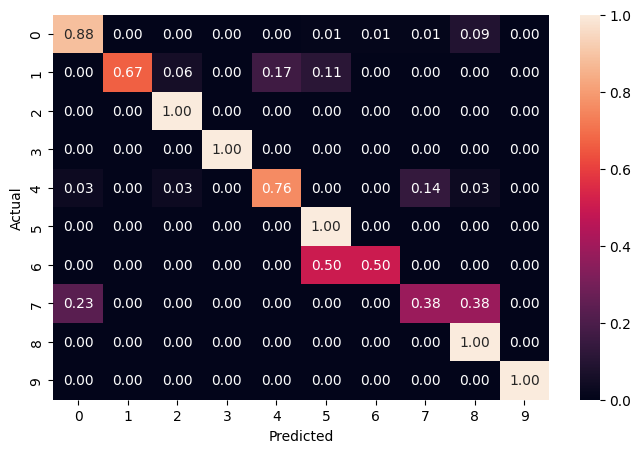

---------------------------------------------------------------------------------------------------

Model TPSM1 with lr = 0.001
F1 scores 
 - Test (20Jul): 85% 
 - Train: 98% 
 - Validation (y_test): 88%

CM for 20Jul data: 


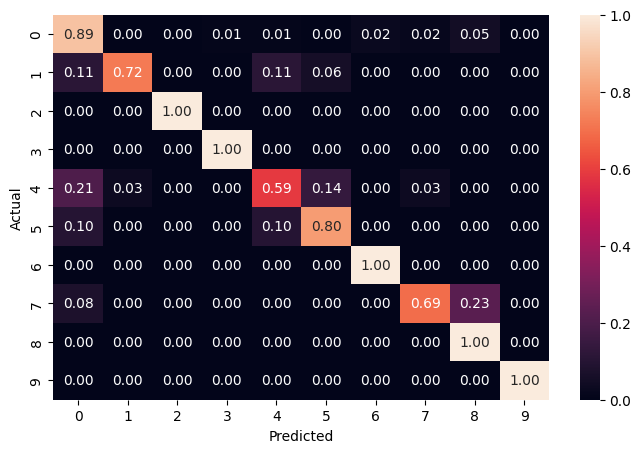

---------------------------------------------------------------------------------------------------

Model TPSM2 with lr = 0.0015
F1 scores 
 - Test (20Jul): 81% 
 - Train: 93% 
 - Validation (y_test): 88%

CM for 20Jul data: 


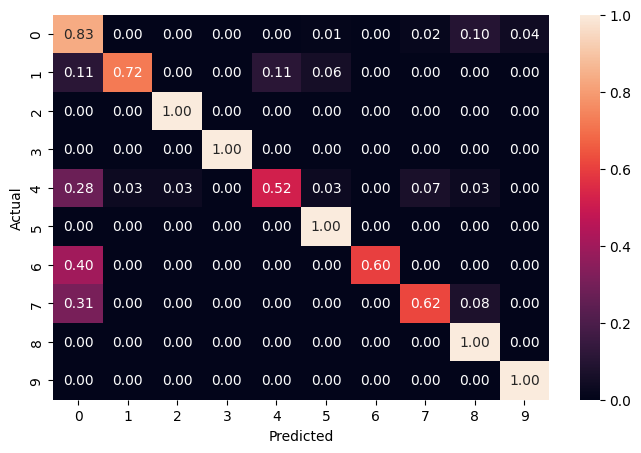

---------------------------------------------------------------------------------------------------

Model TPSM_expLR with lr = 0.01
F1 scores 
 - Test (20Jul): 77% 
 - Train: 90% 
 - Validation (y_test): 86%

CM for 20Jul data: 


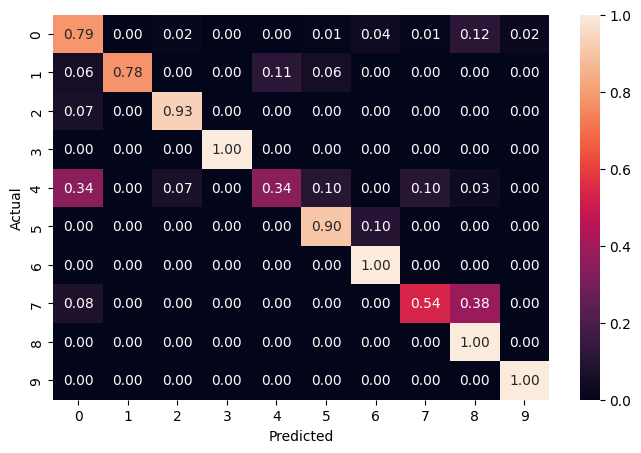

---------------------------------------------------------------------------------------------------

Model TPSM_expLR1 with lr = 0.015
F1 scores 
 - Test (20Jul): 70% 
 - Train: 87% 
 - Validation (y_test): 80%

CM for 20Jul data: 


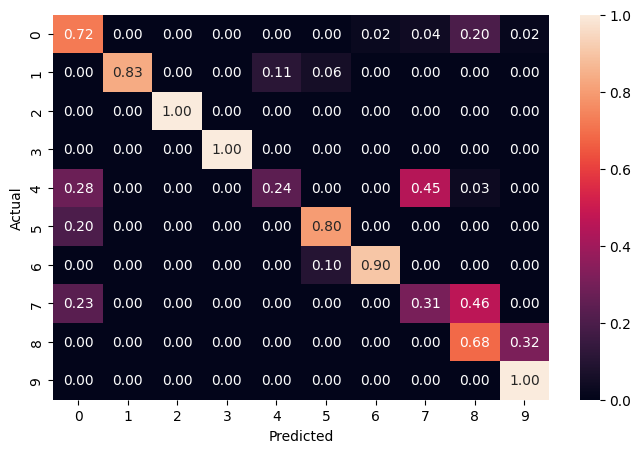

---------------------------------------------------------------------------------------------------



In [69]:
for m in TPSM_models.keys():
    torch.save(TPSM_models[m], f'{m}')
    print(f"Model {m} with lr = {TPSM_lrs[m]}")
    y_pred = TPSM_models[m](X_20jul)
    y_train_pred = TPSM_models[m](X_train)
    y_test_pred = TPSM_models[m](X_test)

    f1 = MulticlassF1Score(num_classes= 10)
    print(f"F1 scores \n - Test (20Jul): {f1(y_pred, y_20jul).item() * 100:.0f}% \n - Train: {f1(y_train_pred, y_train).item() * 100:.0f}% \n - Validation (y_test): {f1(y_test_pred, y_test).item() * 100:.0f}%")

    _, predicted = torch.max(y_pred, 1)
    predicted = predicted.numpy()
    actual = y_20jul.numpy()

    cm = metrics.confusion_matrix(actual,  predicted)
    
    print("\nCM for 20Jul data: ")

    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)
    plt.show()
    print('---------------------------------------------------------------------------------------------------\n')

# Retrain K model

Here we retrain the previously trained deep model on KS device's data trained on the Knotebook.

In [34]:
TPSMk = torch.load("K models\\93F1_4layerDeep_K.pth")

acc = model_train(TPSMk, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights)
print(f"Achieved F1 Score: {acc:.2f}%")

Epoch 0/1000; F1 Score: 15.582733154296875; Loss: 27.185367584228516
Epoch 100/1000; F1 Score: 82.23204803466797; Loss: 0.023639898747205734
Epoch 200/1000; F1 Score: 84.1220474243164; Loss: 0.005967758595943451
Epoch 300/1000; F1 Score: 84.66006469726562; Loss: 0.0018962171161547303
Epoch 400/1000; F1 Score: 82.22846984863281; Loss: 0.000790895544923842
Epoch 500/1000; F1 Score: 80.6972885131836; Loss: 0.000494876061566174
Epoch 600/1000; F1 Score: 80.38177490234375; Loss: 0.00030935308313928545
Epoch 700/1000; F1 Score: 79.57078552246094; Loss: 0.00016540422802791
Epoch 800/1000; F1 Score: 81.435791015625; Loss: 0.0001545035484014079
Epoch 900/1000; F1 Score: 79.8861083984375; Loss: 8.914436330087483e-05
Achieved F1 Score: 86.47%


In [35]:
TPSMk1 = torch.load("K models\\93F1_4layerDeep_K.pth")

acc = model_train(TPSMk1, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights, lr = 1.5e-3)
print(f"Achieved F1 Score: {acc:.2f}%")

Epoch 0/1000; F1 Score: 28.942880630493164; Loss: 2.3394787311553955
Epoch 100/1000; F1 Score: 80.52782440185547; Loss: 0.006298761814832687
Epoch 200/1000; F1 Score: 79.96365356445312; Loss: 0.04285227134823799
Epoch 300/1000; F1 Score: 83.68964385986328; Loss: 0.019063860177993774
Epoch 400/1000; F1 Score: 81.96868896484375; Loss: 0.004922540858387947
Epoch 500/1000; F1 Score: 82.36811828613281; Loss: 0.00023440014047082514
Epoch 600/1000; F1 Score: 81.32001495361328; Loss: 5.832479018863523e-06
Epoch 700/1000; F1 Score: 80.79327392578125; Loss: 0.002588399453088641
Epoch 800/1000; F1 Score: 83.62309265136719; Loss: 0.00015018896374385804
Epoch 900/1000; F1 Score: 83.296142578125; Loss: 0.03530555218458176
Achieved F1 Score: 86.82%


In [36]:
TPSMk2 = torch.load("K models\\93F1_4layerDeep_K.pth")

acc = model_train(TPSMk2, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights, lr = 1e-2)
print(f"Achieved F1 Score: {acc:.2f}%")

Epoch 0/1000; F1 Score: 40.53349304199219; Loss: 3.459059000015259
Epoch 100/1000; F1 Score: 82.7297592163086; Loss: 0.033500391989946365
Epoch 200/1000; F1 Score: 55.379390716552734; Loss: 0.07334341108798981
Epoch 300/1000; F1 Score: 75.05852508544922; Loss: 0.0655374526977539
Epoch 400/1000; F1 Score: 79.7321548461914; Loss: 0.014238658361136913
Epoch 500/1000; F1 Score: 75.25679779052734; Loss: 0.029591262340545654
Epoch 600/1000; F1 Score: 80.04585266113281; Loss: 0.02960096299648285
Epoch 700/1000; F1 Score: 57.87519836425781; Loss: 2.8254241943359375
Epoch 800/1000; F1 Score: 63.71759033203125; Loss: 0.08730120211839676
Epoch 900/1000; F1 Score: 63.451622009277344; Loss: 0.10216251760721207
Achieved F1 Score: 86.73%


In [76]:
TPSMk_expLR = torch.load("K models\\93F1_4layerDeep_K.pth")

acc = model_train(TPSMk_expLR, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights, lr = 1e-2, lr_step = True)
print(f"Achieved F1 Score: {acc:.2f}%")

Epoch 0/1000; F1 Score: 40.53349304199219; Loss: 3.459059000015259
Epoch 100/1000; F1 Score: 86.06229400634766; Loss: 0.004651085939258337
Epoch 200/1000; F1 Score: 82.65731048583984; Loss: 0.002536851679906249
Epoch 300/1000; F1 Score: 81.51799774169922; Loss: 2.0980833070893823e-08
Epoch 400/1000; F1 Score: 81.6257095336914; Loss: 0.0
Epoch 500/1000; F1 Score: 80.90440368652344; Loss: 0.0
Epoch 600/1000; F1 Score: 80.29630279541016; Loss: 0.0
Epoch 700/1000; F1 Score: 80.58201599121094; Loss: 0.0
Epoch 800/1000; F1 Score: 80.58201599121094; Loss: 0.0
Epoch 900/1000; F1 Score: 79.99755096435547; Loss: 0.0
Achieved F1 Score: 86.67%


In [77]:
TPSMk_expLR1 = torch.load("K models\\93F1_4layerDeep_K.pth")

acc = model_train(TPSMk_expLR1, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights, lr = 1.5e-2, lr_step = True)
print(f"Achieved F1 Score: {acc:.2f}%")

Epoch 0/1000; F1 Score: 30.429929733276367; Loss: 7.978161811828613
Epoch 100/1000; F1 Score: 81.62664031982422; Loss: 0.01090648490935564
Epoch 200/1000; F1 Score: 81.94232940673828; Loss: 0.03035275824368
Epoch 300/1000; F1 Score: 83.27223205566406; Loss: 0.041143711656332016
Epoch 400/1000; F1 Score: 82.82820892333984; Loss: 0.01524666789919138
Epoch 500/1000; F1 Score: 84.47579956054688; Loss: 0.0022360519506037235
Epoch 600/1000; F1 Score: 85.52958679199219; Loss: 0.0010778193827718496
Epoch 700/1000; F1 Score: 84.84928131103516; Loss: 0.0009357978124171495
Epoch 800/1000; F1 Score: 84.84928131103516; Loss: 0.00090793491108343
Epoch 900/1000; F1 Score: 85.14641571044922; Loss: 0.0009039479191415012
Achieved F1 Score: 86.10%


### Test on July 20th data

In [78]:
TPSMk_models = {'TPSMk': TPSMk, 'TPSMk1': TPSMk1, 'TPSMk2': TPSMk2, 'TPSMk_expLR': TPSMk_expLR, 'TPSMk_expLR1': TPSM_expLR1}
TPSMk_lrs = {'TPSMk': 1e-4, 'TPSMk1': 1e-3, 'TPSMk2': 1.5e-3, 'TPSMk_expLR': 1e-2, 'TPSMk_expLR1': 1.5e-2}

Model TPSMk with lr = 0.0001
F1 scores 
 - Test (20Jul): 83% 
 - Train: 92% 
 - Validation (y_test): 86%

CM for 20Jul data: 


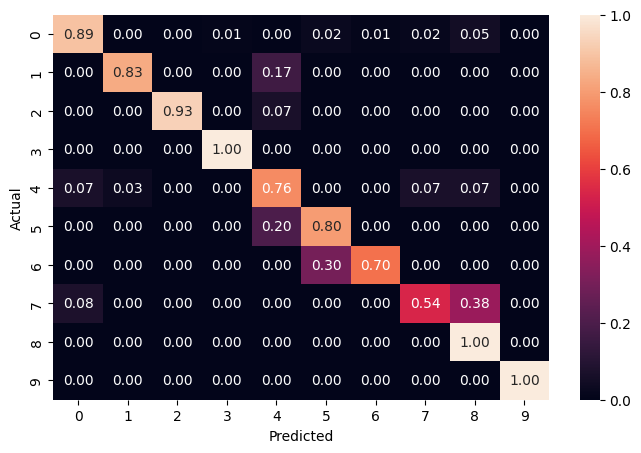

---------------------------------------------------------------------------------------------------

Model TPSMk1 with lr = 0.001
F1 scores 
 - Test (20Jul): 77% 
 - Train: 96% 
 - Validation (y_test): 87%

CM for 20Jul data: 


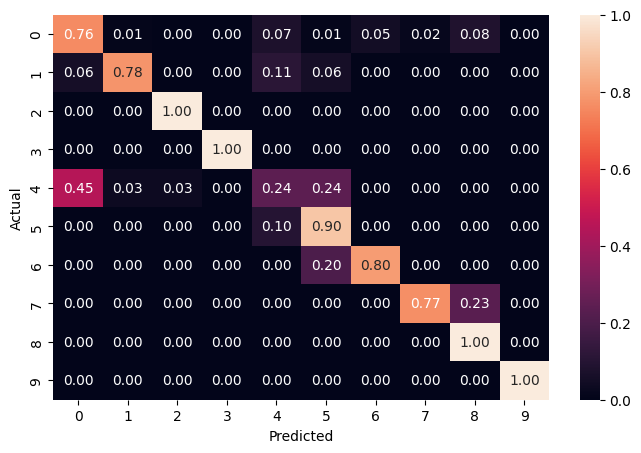

---------------------------------------------------------------------------------------------------

Model TPSMk2 with lr = 0.0015
F1 scores 
 - Test (20Jul): 82% 
 - Train: 91% 
 - Validation (y_test): 87%

CM for 20Jul data: 


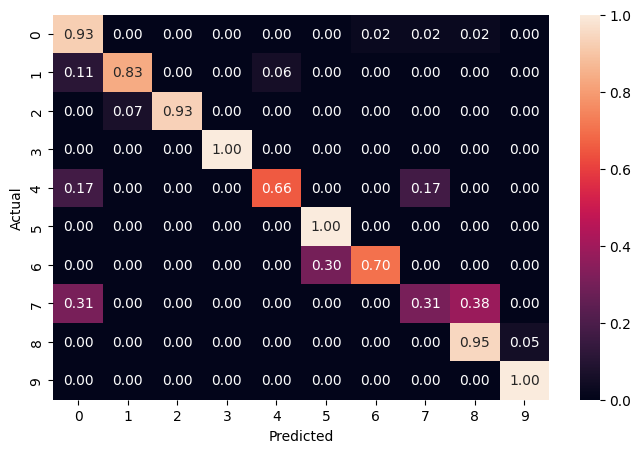

---------------------------------------------------------------------------------------------------

Model TPSMk_expLR with lr = 0.01
F1 scores 
 - Test (20Jul): 84% 
 - Train: 92% 
 - Validation (y_test): 87%

CM for 20Jul data: 


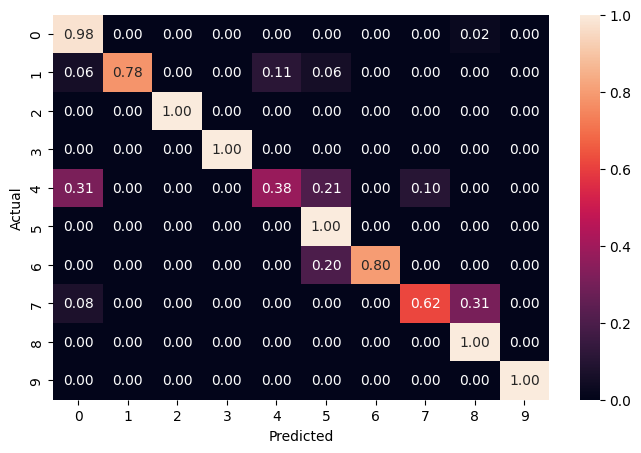

---------------------------------------------------------------------------------------------------

Model TPSMk_expLR1 with lr = 0.015
F1 scores 
 - Test (20Jul): 75% 
 - Train: 89% 
 - Validation (y_test): 86%

CM for 20Jul data: 


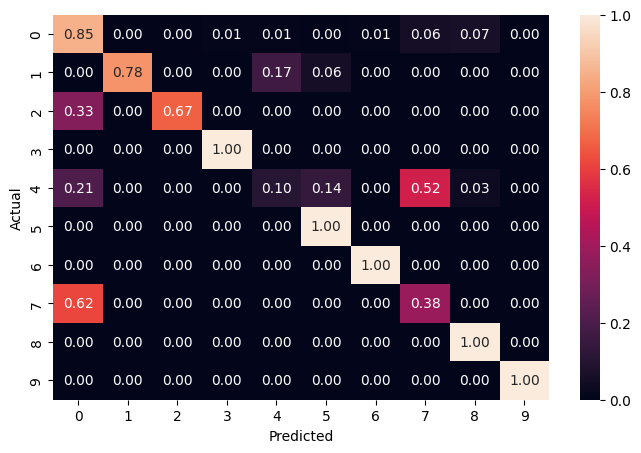

---------------------------------------------------------------------------------------------------



In [79]:
for m in TPSMk_models.keys():
    torch.save(TPSMk_models[m], f'{m}.pth')
    print(f"Model {m} with lr = {TPSMk_lrs[m]}")
    y_pred = TPSMk_models[m](X_20jul)
    y_train_pred = TPSMk_models[m](X_train)
    y_test_pred = TPSMk_models[m](X_test)

    f1 = MulticlassF1Score(num_classes= 10)
    print(f"F1 scores \n - Test (20Jul): {f1(y_pred, y_20jul).item() * 100:.0f}% \n - Train: {f1(y_train_pred, y_train).item() * 100:.0f}% \n - Validation (y_test): {f1(y_test_pred, y_test).item() * 100:.0f}%")

    _, predicted = torch.max(y_pred, 1)
    predicted = predicted.numpy()
    actual = y_20jul.numpy()

    cm = metrics.confusion_matrix(actual,  predicted)
    
    print("\nCM for 20Jul data: ")

    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)
    plt.show()
    print('---------------------------------------------------------------------------------------------------\n')